<a href="https://colab.research.google.com/github/msa-1988/-CIFAR-10_Image_classification_CNN/blob/main/CIFAR_10_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**About the dataset:**

The **CIFAR-10** dataset is a widely used benchmark dataset for image classification tasks. It consists of 60,000 color images in the RGB format, with dimensions of 32x32 pixels. The dataset is divided into 50,000 training images and 10,000 testing images.

The CIFAR-10 dataset contains images from 10 different classes, with each class representing a specific object or concept. The classes include:

Airplane
Automobile
Bird
Cat
Deer
Dog
Frog
Horse
Ship
Truck
The dataset provides a balanced distribution of images across these classes, with 6,000 images per class. This balance ensures that the models trained on the dataset have an equal representation of each class, allowing for fair evaluation and comparison.

The CIFAR-10 dataset is commonly used for training and evaluating image classification models, particularly deep learning models such as Convolutional Neural Networks (CNNs). Due to its relatively small image size and limited complexity, it serves as a starting point for researchers and practitioners to develop and test their algorithms before moving on to more challenging datasets.

# Importing the necessary libraries:

In [50]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F

Check for GPU

In [51]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Loading and preprocessing the CIFAR10 dataset:

In [52]:
# Define transformations for the dataset
transform_train = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the MNIST dataset
train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [53]:
# Get the label-to-integer mapping
label_map = train_dataset.class_to_idx

# Invert the label-to-integer mapping to get original labels
original_labels = {v: k for k, v in label_map.items()}

# Print the original labels
print(original_labels)
print("label_map = ",label_map)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
label_map =  {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


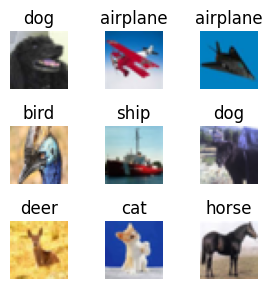

In [54]:
## Visualize a sample of training data
import matplotlib.pyplot as plt

# Plot the data
figure = plt.figure(figsize=(3, 3))
row, col = 3, 3
for i in range(1, row * col + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    img = torch.transpose(img, 0,2)  # Transpose dimensions (channels, height, width) to (height, width, channels)
    img = torch.transpose(img, 1,0)  # Transpose dimensions (channels, height, width) to (height, width, channels)
    figure.add_subplot(row, col, i)
    plt.title(original_labels[label])
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [55]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
        self.RN1 = nn.LocalResponseNorm(8)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
        self.RN2 = nn.LocalResponseNorm(16)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1 = nn.Linear(8 * 4 *4, 32)
        self.dropout1 = nn.Dropout2d(0.25)

        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.RN1(x)
        x = self.pool1(x)
        # print("step 1 ", x.shape)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.RN2(x)
        x = self.pool2(x)
        # print("step 2 ", x.shape)

        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        # print("step 3 ", x.shape)

        x = x.view(x.size(0), -1)
        # print("step 4 ", x.shape)

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output


The model ConvNet is a Convolutional Neural Network (CNN) designed for image classification tasks. Here is a brief explanation of its structure and operations:

Input: The model expects input images with 3 channels (e.g., RGB images) and is designed to classify them into one of 10 classes.

Convolutional Layers: The model has three convolutional layers (conv1, conv2, and conv3) that apply convolutional operations to the input images. These layers extract features from the input using learnable filters.

Local Response Normalization: The model applies local response normalization after each convolutional layer (RN1 and RN2). This operation enhances the contrast of the features and improves the model's ability to generalize.

Max Pooling Layers: The model includes three max pooling layers (pool1, pool2, and pool3) that reduce the spatial dimensions of the feature maps, helping to capture the most important information while reducing the computational cost.

Fully Connected Layers: After the convolutional and pooling layers, the model has two fully connected layers (fc1 and fc2). The first fully connected layer has 32 neurons, and the second fully connected layer produces the final classification scores for the 10 classes.

ReLU Activation: Rectified Linear Unit (ReLU) activation functions are applied after each convolutional layer and the first fully connected layer (torch.relu). ReLU introduces non-linearity to the model, allowing it to learn complex patterns in the data.

Dropout: The model includes a dropout layer (dropout1) after the first fully connected layer. Dropout randomly sets a fraction of input units to zero during training, which helps prevent overfitting and improves generalization.

Softmax Activation: The final output of the model is passed through a softmax activation function (F.log_softmax) along the dimension 1. This converts the raw scores into a probability distribution over the 10 classes, indicating the model's confidence for each class.

Overall, this model consists of convolutional layers to extract hierarchical features, pooling layers for spatial reduction, fully connected layers for classification, and activation functions to introduce non-linearity. It follows a common architecture pattern used in CNNs for image classification tasks.



In [56]:
class v2ConvNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(v2ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output


In [57]:
class v3ConvNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(v3ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.lrn1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
#         self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv12 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.lrn12 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
        self.pool12 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.lrn2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.lrn3 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.dropout = nn.Dropout(0.5)

        self.fc12 = nn.Linear(512,128)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.lrn1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv12(x)
        x = self.lrn12(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
#         x = self.lrn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
#         x = self.lrn3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc12(x)
        x = F.relu(x)
        x = self.dropout(x)


        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),  # Modified kernel size and padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=2),  # Modified kernel size and padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


Create an instance of CNN, define the loss function, and optimiser

In [59]:
# Create an instance of the CNN and move it to the GPU
# Select a cnn model from above : ConvNet,v2ConvNet,v3ConvNetv,AlexNetCIFAR
cnn = v3ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(),lr=0.001)

In [60]:
# Train the CNN
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)  # Move inputs to the GPU
        labels = labels.to(device)  # Move labels to the GPU
        # print(inputs.shape)
        # input("presse")

        optimizer.zero_grad() ## Clear out gradients
        outputs = cnn(inputs) ## Pass the inputs and obtain the output of the cnn model
        loss = criterion(outputs, labels) ## Computer the loss
        loss.backward() ## Apply back propagation
        optimizer.step() ## Update the weights

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch: {epoch+1}, Batch: {i+1}, Loss: {running_loss/100:.3f}')
            running_loss = 0.0

Epoch: 1, Batch: 100, Loss: 2.210
Epoch: 1, Batch: 200, Loss: 2.010
Epoch: 1, Batch: 300, Loss: 1.844
Epoch: 1, Batch: 400, Loss: 1.757
Epoch: 1, Batch: 500, Loss: 1.704
Epoch: 1, Batch: 600, Loss: 1.608
Epoch: 1, Batch: 700, Loss: 1.541
Epoch: 2, Batch: 100, Loss: 1.466
Epoch: 2, Batch: 200, Loss: 1.410
Epoch: 2, Batch: 300, Loss: 1.355
Epoch: 2, Batch: 400, Loss: 1.380
Epoch: 2, Batch: 500, Loss: 1.324
Epoch: 2, Batch: 600, Loss: 1.317
Epoch: 2, Batch: 700, Loss: 1.302
Epoch: 3, Batch: 100, Loss: 1.186
Epoch: 3, Batch: 200, Loss: 1.180
Epoch: 3, Batch: 300, Loss: 1.164
Epoch: 3, Batch: 400, Loss: 1.126
Epoch: 3, Batch: 500, Loss: 1.119
Epoch: 3, Batch: 600, Loss: 1.116
Epoch: 3, Batch: 700, Loss: 1.130
Epoch: 4, Batch: 100, Loss: 1.031
Epoch: 4, Batch: 200, Loss: 1.030
Epoch: 4, Batch: 300, Loss: 1.011
Epoch: 4, Batch: 400, Loss: 1.005
Epoch: 4, Batch: 500, Loss: 0.984
Epoch: 4, Batch: 600, Loss: 0.967
Epoch: 4, Batch: 700, Loss: 1.001
Epoch: 5, Batch: 100, Loss: 0.893
Epoch: 5, Batc

Evaluating the neural network on test data:

In [61]:
# Evaluate the CNN on the test data
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Move inputs to the GPU
        labels = labels.to(device)  # Move labels to the GPU

        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Compute precision, recall, and f1-score
report = classification_report(labels.cpu(), predicted.cpu())

# Print the report
print(report)


Test Accuracy: 72.78%
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       0.75      1.00      0.86         3
           4       0.00      0.00      0.00         0
           5       1.00      0.67      0.80         3
           7       1.00      1.00      1.00         3
           8       1.00      0.67      0.80         3

    accuracy                           0.81        16
   macro avg       0.68      0.67      0.66        16
weighted avg       0.85      0.81      0.81        16



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

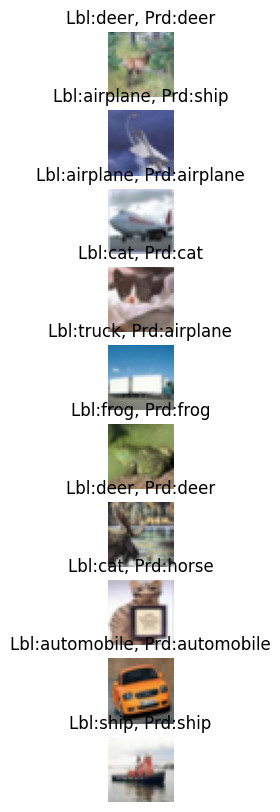

Predictions: [4, 8, 0, 3, 0, 6, 4, 7, 1, 8]


In [62]:
# Function to plot images
def plot_images(images, labels, predictions,original_labels):
    fig, axes = plt.subplots(len(images),1, figsize=(5, 10))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax.set_title(f'Lbl:{original_labels[labels[i]]}, Prd:{original_labels[predictions[i]]}')
        ax.axis('off')
    plt.show()

# Get some random test images and labels
num_images_to_plot = 10
random_indices = torch.randperm(len(test_dataset))[:num_images_to_plot]
images = torch.stack([test_dataset[i][0] for i in random_indices])
images = images.to(device)
labels = torch.tensor([test_dataset[i][1] for i in random_indices])
labels = labels.to(device)

# Make predictions on the test images
with torch.no_grad():
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)

# Move images, labels, and predictions to the CPU
# images = torch.transpose(images, 1, 2).transpose(1, 3)  # Transpose dimensions (channels, height, width) to (height, width, channels)
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Convert tensor labels and predictions to lists
labels = labels.tolist()
predicted = predicted.tolist()

# Plot the test images with labels and predictions
plot_images(images, labels, predicted,original_labels)

# Print the predictions
print('Predictions:', predicted)


In conclusion, throughout this project, I have designed and trained multiple CNN models for image classification on the CIFAR10 dataset. While the achieved accuracy of around 75% may not be comparable to the state-of-the-art performance, I am satisfied with the progress made and the experience gained in all the steps of designing, training, and evaluating CNN models.

Working on this project has provided me with valuable insights into the intricacies of CNN architecture, data preprocessing, model training, and evaluation. It has also highlighted the importance of hyperparameter tuning and experimentation to improve model performance.

Although the current results may not be groundbreaking, I am motivated to continue exploring and developing more advanced CNN models in the future. I believe that with further research, fine-tuning, and potentially incorporating state-of-the-art techniques, I can achieve higher accuracy and tackle more complex image classification tasks.

This colab notebook represents a significant milestone in my journey, showcasing my ability to work with CNNs and demonstrating my dedication to learning and improving in the field of deep learning. I am excited to continue my exploration of CNNs and pursue further advancements in the domain.

Good luck to anyone reviewing this notebook, and thank you for the opportunity to showcase my work!
